In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

## Imagenet V1 MRL Oracle Performance

Just change the dataset and make sure you have the predictions and the ground set ready. This will compute the oracle upper bound

In [38]:
single_head=False
multi_head=True
fixed_feature=False
feat_dim=2048
dataset="V1"
prediction = torch.load(f"predictions/predictions_sh={single_head}_mh={multi_head}_ff={fixed_feature}_feat_dim={feat_dim}_dataset={dataset}.pth")
gt = torch.load(f'ground_truth/gt_dataset={dataset}.pth')

In [39]:
print("Majority Ensemble Performance", ((torch.mode(prediction, dim=0)[0]).cuda()==gt.cuda()).sum(dim=-1)/len(gt))

Majority Ensemble Performance tensor(0.7677, device='cuda:0')


In [40]:
corr = (prediction.cuda()==gt.cuda())

In [41]:
M,N = corr.shape
oracle_ = []
class_={i:[] for i in range(1000)}
tot_corr=0
for i in range(N):
    smallest_idx = M-1
    for j in range(M):
        id = M-j-1
        if id==M-1:
            continue
        else:
            if corr[id, i]:
                smallest_idx=id
    if corr[smallest_idx, i]:
        tot_corr+=1
    oracle_.append(smallest_idx)      
    class_[gt[i].item()].append(smallest_idx)

In [42]:
import collections
counter=collections.Counter(oracle_)

In [43]:
oracle_hist = np.asarray([counter[k] for k in range(9)])

In [44]:
import seaborn as sns
sns.set_context("talk")
sns.set_style("whitegrid")

In [46]:
print(100*oracle_hist/len(gt))
print([2**(i+3) for i in range(9)])

[67.462  8.782  2.588  1.358  0.642  0.318  0.204  0.128 18.518]
[8, 16, 32, 64, 128, 256, 512, 1024, 2048]


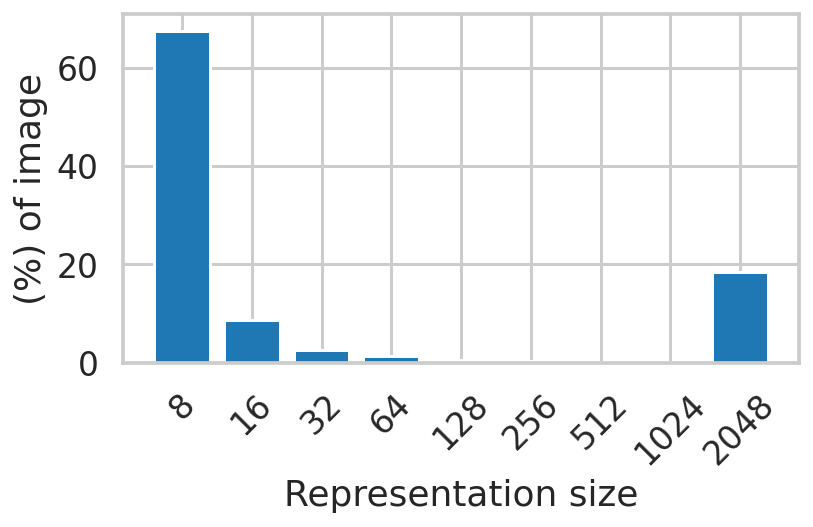

In [48]:
plt.bar([i for i in range(9)], 100*oracle_hist/len(gt))
plt.xticks([i for i in range(9)], [2**(i+3) for i in range(9)], rotation=45)
plt.xlabel("Representation size")
plt.ylabel("(%) of image")
plt.tight_layout()
# plt.savefig("oracle_dist.pdf")
plt.show()

In [49]:
def compute_expected_dim(counter, norm):
    dim=0
    for c in counter.keys():
        dim+= (counter[c]/norm)*2**(c+3)
    return dim
    

In [50]:
compute_expected_dim(counter, len(gt))

391.73904000000005

In [51]:
def calc_acc_from_oracle(oracle_, pred, gt):
    corr=0
    for i in range(len(gt)):
        model_id = oracle_[i]
        if gt[i]==pred[model_id][i]:
            corr+=1
    return corr/len(gt)

In [52]:
acc = calc_acc_from_oracle(oracle_, prediction.cuda(), gt.cuda())
print(f"Oracle Performance on dataset Imagenet {dataset}:",100*(acc))

Oracle Performance on dataset Imagenet V1: 81.542
